# Matteo_Challenge1: Hand-Crafted Solution

## Import libraries

In [76]:
import os
import random
from datetime import datetime

import splitfolders

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from keras.models import load_model
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [77]:
# Checking tensorflow version
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [78]:
# Setting seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Model Parameters and Classes Weights

In [79]:
labels = ['Species1',      # 0
          'Species2',      # 1
          'Species3',      # 2
          'Species4',      # 3
          'Species5',      # 4
          'Species6',      # 5
          'Species7',      # 6
          'Species8']      # 7

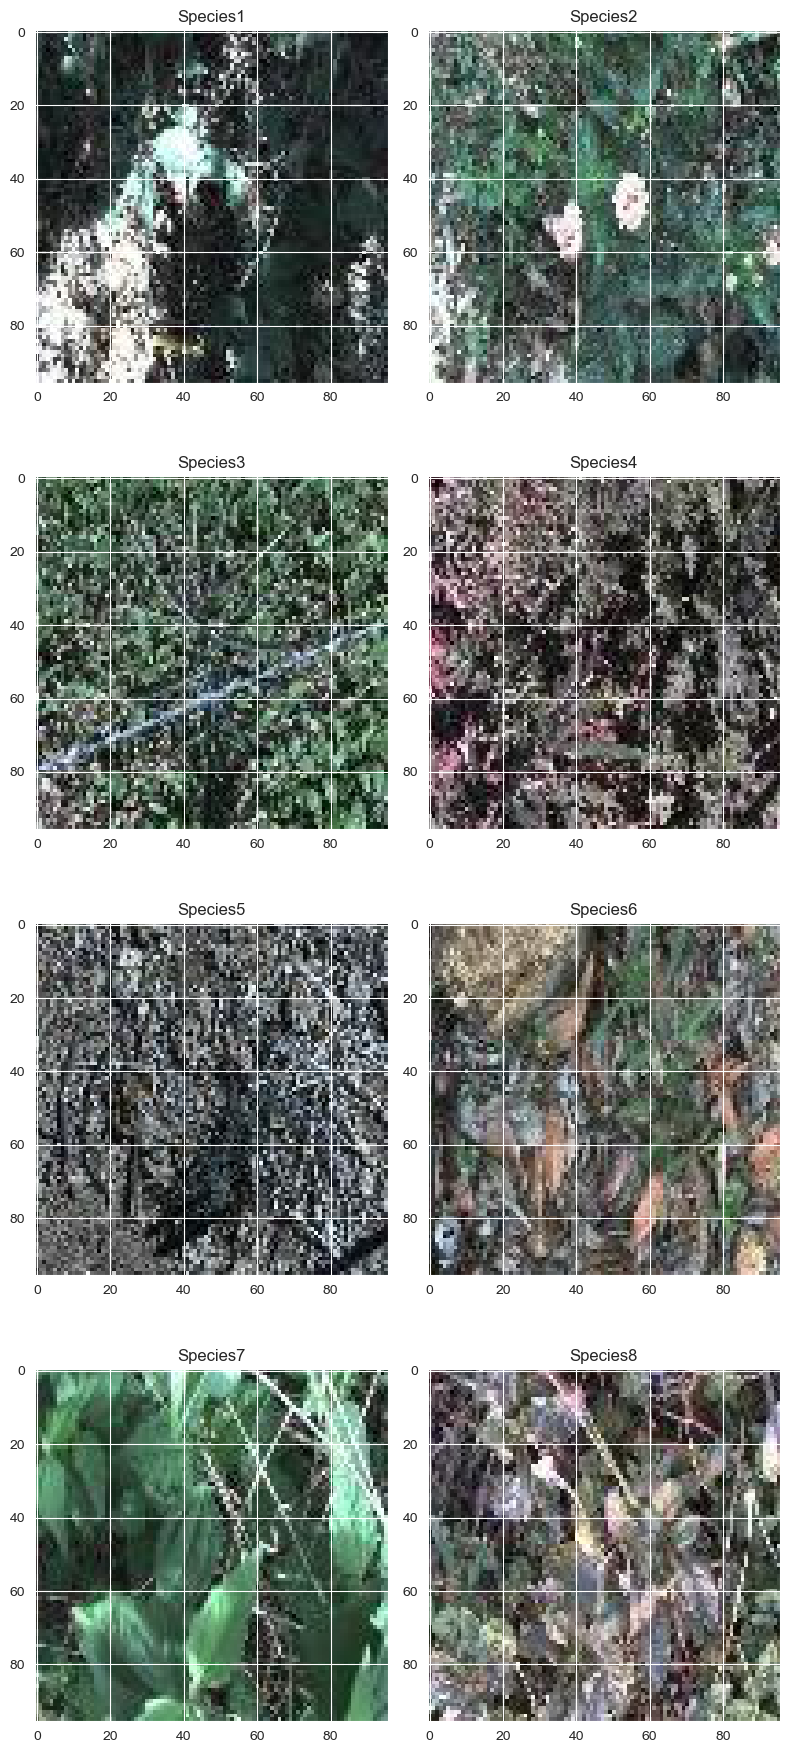

In [80]:
dataset_dir = 'Dataset'

num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(num_row*num_col):
    if i < 8:
        class_imgs = next(os.walk('{}/{}'.format(dataset_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

## Model Parameters and Metadata

In [81]:
# Input Parameters
img_w = 96
img_h = 96
input_shape = (96, 96, 3)
classes = 8

# Training Parameters
epochs = 90
batch_size = 64
reg_rate = 0.001

# Earlystopping Parameters
early_stopping = False
patience_epochs = 9

# Training and Validation Folders
training_dir = os.path.join(dataset_dir, '../datasetWithoutTest/train')
validation_dir = os.path.join(dataset_dir, '../datasetWithoutTest/val')

## Data Augmentation

In [82]:
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()

In [83]:
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=labels,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96, 96),
                                               color_mode='rgb',
                                               classes=labels,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)

Found 5658 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


In [84]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [85]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))

    return batch

(Input) image shape: (64, 96, 96, 3)
Target shape: (64, 8)

Categorical label: [0. 0. 0. 0. 0. 1. 0. 0.]
Label: 5
Class name: Species6


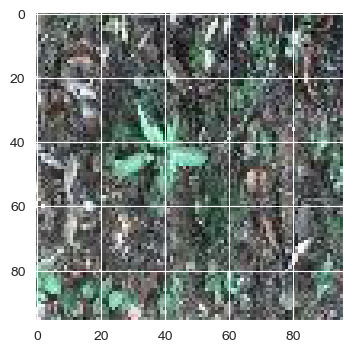

In [86]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

## Data Augmentation


Rotation: {'theta': -7.527592869158251, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': 38, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 0.9247240713084175, 'zy': 1.2704285838459497, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



Text(0.5, 1.0, 'Rescaled')

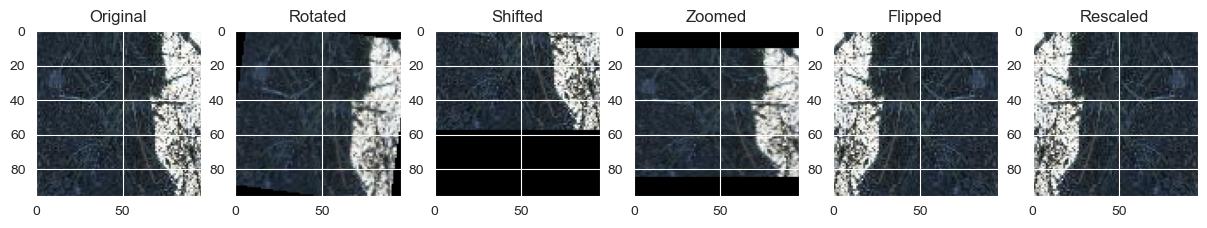

In [87]:
# Create some augmentation examples
# Get sample image
image = next(train_gen)[0][4]

# Create an instance of ImageDataGenerator for each transformation
rot_gen = ImageDataGenerator(rotation_range=30)
shift_gen = ImageDataGenerator(width_shift_range=50)
zoom_gen = ImageDataGenerator(zoom_range=0.3)
flip_gen = ImageDataGenerator(horizontal_flip=True)
rescale_gen = ImageDataGenerator(rescale=1/255.)

# Get random transformations
rot_t = rot_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Flip:', flip_t, '\n')
rescale_t = rescale_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Flip:', rescale_t, '\n')

# Apply the transformation
gen = ImageDataGenerator(fill_mode='constant', cval=0.)
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t)
zoomed = gen.apply_transform(image, zoom_t)
flipped = gen.apply_transform(image, flip_t)
rescaled = gen.apply_transform(image, rescale_t)

# Plot original and augmented images
fig, ax = plt.subplots(1, 6, figsize=(15, 45))
ax[0].imshow(np.uint8(image))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped))
ax[4].set_title('Flipped')
ax[5].imshow(np.uint8(flipped))
ax[5].set_title('Rescaled')

In [88]:
aug_train_data_gen =  ImageDataGenerator(rotation_range=10,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         brightness_range=[0.2,1.2],
                                         fill_mode='nearest',
                                         rescale=1/255.)

In [89]:
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=labels,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

Found 5658 images belonging to 8 classes.


Transform: {'theta': -7.527592869158251, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None}


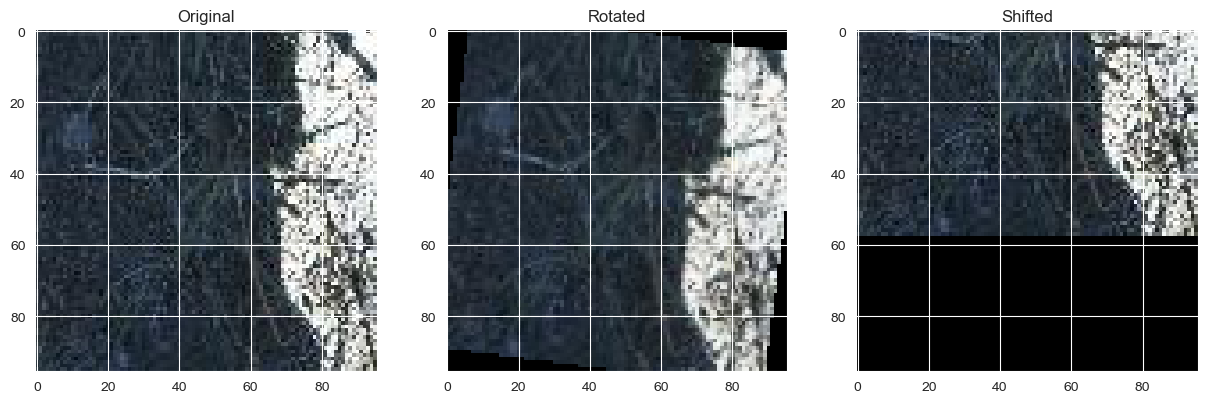

In [90]:
# Get random transformation
rot_t = rot_gen.get_random_transform(img_shape=(256, 256), seed=seed)
shift_t = shift_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print("Transform:", rot_t)

# Apply the transformation
augmented = gen.apply_transform(image, rot_t)
augmented2 = gen.apply_transform(image, shift_t)


# Plot original and augmented images
fig, ax = plt.subplots(1, 3, figsize=(15,30))
ax[0].imshow(np.uint8(image))
ax[0].set_title("Original")
ax[1].imshow(np.uint8(augmented))
ax[1].set_title("Rotated")
ax[2].imshow(np.uint8(augmented2))
ax[2].set_title("Shifted")
plt.show()

## CNN Model

In [91]:
def build_model(input_shape):

    # Layer Input -------------------------------------------------------
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Layer 1 -----------------------------------------------------------
    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    conv1 = tfkl.BatchNormalization()(conv1)
    pool1 = tfkl.MaxPooling2D()(conv1)

    # Layer 2 -----------------------------------------------------------
    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    conv2 = tfkl.BatchNormalization()(conv2)

    pool2 = tfkl.MaxPooling2D()(conv2)

    # Layer 3 -----------------------------------------------------------
    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    conv3 = tfkl.BatchNormalization()(conv3)
    pool3 = tfkl.MaxPooling2D()(conv3)

    # Layer 4 -----------------------------------------------------------
    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    conv4 = tfkl.BatchNormalization()(conv4)
    pool4 = tfkl.MaxPooling2D()(conv4)

    # Layer 5 -----------------------------------------------------------
    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    conv5 = tfkl.BatchNormalization()(conv5)
    pool5 = tfkl.MaxPooling2D()(conv5)

    # Global Average Pooling -----------------------------------------------------------
    glob_pooling = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(pool5)


    # Dense Layer -----------------------------------------------------------
    classifier_layer1 = tfkl.Dense(units=512, name='Classifier1', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer = l2(0.01))(glob_pooling)

    classifier_layer1 = tfkl.BatchNormalization()(classifier_layer1)

    leaky_relu_layer1 = tfkl.LeakyReLU()(classifier_layer1)

    leaky_relu_layer2 = tfkl.Dropout(0.3, seed=seed)(leaky_relu_layer1)

    # Output Layer -----------------------------------------------------------
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(leaky_relu_layer2)

    # Model Creation -----------------------------------------------------------
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                  optimizer=tfk.optimizers.Adam(),
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [92]:
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                             

## Utility Callbacks

In [93]:
# Utility function to create folders and callbacks for training
def create_folders_and_callbacks(model_name) :
    exps_dir = os.path.join('data_augmentation_experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = []

    # Model checkpoint ---------------------------------------------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'), # filepath is where I want to save the model
                                                     save_weights_only=False, # save only the weights ora all the model
                                                     save_best_only=True) # if True saves only the results of the best epoch

    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard ----------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs') # logs where we save the events, where the tensorboard will read the logs
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                              profile_batch=0,
                                              histogram_freq=1)
    callbacks.append(tb_callback)

    # Early Stopping -----------------------------------------------------
    if early_stopping:
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_epochs, restore_best_weights=True)
        callbacks.append(es_callback)

    return callbacks

## Training

In [94]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='HandCrafted_CNN_DenseChange')

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = 90,
    validation_data = valid_gen,
    callbacks = callbacks,
).history

Epoch 1/90


2022-11-15 12:44:51.617268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 5.3150 - accuracy: 0.3662 - precision_3: 0.4799 - recall_3: 0.1561

2022-11-15 12:45:02.276601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_DenseChange_Nov15_12-44-51/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_DenseChange_Nov15_12-44-51/ckpts/cp/assets


89/89 [==============================] - 14s 143ms/step - loss: 5.3150 - accuracy: 0.3662 - precision_3: 0.4799 - recall_3: 0.1561 - val_loss: 171.7606 - val_accuracy: 0.1893 - val_precision_3: 0.1893 - val_recall_3: 0.1893
Epoch 2/90
89/89 [==============================] - 10s 112ms/step - loss: 3.0932 - accuracy: 0.4148 - precision_3: 0.5430 - recall_3: 0.2131 - val_loss: 267.5767 - val_accuracy: 0.1501 - val_precision_3: 0.1501 - val_recall_3: 0.1501
Epoch 3/90
89/89 [==============================] - 10s 113ms/step - loss: 2.1514 - accuracy: 0.4560 - precision_3: 0.5743 - recall_3: 0.2499 - val_loss: 368.4858 - val_accuracy: 0.2006 - val_precision_3: 0.2006 - val_recall_3: 0.2006
Epoch 4/90
89/89 [==============================] - 9s 106ms/step - loss: 1.7728 - accuracy: 0.4650 - precision_3: 0.6070 - recall_3: 0.2667 - val_loss: 546.6057 - val_accuracy: 0.2833 - val_precision_3: 0.2833 - val_recall_3: 0.2833
Epoch 5/90
89/89 [==============================] - 10s 108ms/step - los

In [95]:
# Saving the last epoch of the train
save_dir = os.path.join('HandCrafted_CNNCombined')
model.save(save_dir)

KeyboardInterrupt: 

## Graphs Visualization

In [ ]:
# All the metrics : Accuracy, Precision and Recall
ALPHA = 0.3

plt.figure(figsize=(20,10))

plt.plot(history['accuracy'], label='Accuracy Train', alpha=ALPHA, color='#E64A19')
plt.plot(history['val_accuracy'], label='Accuracy Val', alpha=ALPHA, color='#F57C00')

plt.ylim(0, 1)
plt.title('Metrics')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

## Confusion Matrix


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


x,y=get_next_batch(valid_gen)
predictions=model.predict(x)
predictions.shape
cm = confusion_matrix(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))
sns.heatmap(cm.T,xticklabels=list(labels), yticklabels=list(labels))